# Chapter 5: Evaluating and Comparing Learners

In [1]:
from mlwpy import *

diabetes = datasets.load_diabetes()
%matplotlib inline

In [2]:
%%HTML
<style>
    td,th,p{
    font-size: 20px
}
</style>

## 5.1 Evaluation and Why Less Is More

Computer learning systems may be limited by capacity or distracted by noise.
In machine learning, we call the capacity of what we can squeeze into our head the *bias* and we call getting distracted by noise the *variance*.

The most fundamental defense is *not teaching to the test*. To avoid teaching to the test, we use a three-step recipe:

* step one: split the data into separate training and testing sets
* step two: *learn* on the training data
* step three: *evaluate* on the testing data

## 5.2 Terminology for Learning Phases

We have liad out terminology for learning phases, training, selection, and assessment.

If we fail a test, we could attribute failure to distinct options: (1) not bringing enough raw horsepower or capacity to the test and (2) focusing too much on irrelevant details.

Number 2 is really just a case of being distracted by noise. The two sources of error have technical names: *underfitting* and *overfitting*. Let's cook up some practice data to investigate.


### 5.3.1 Synthetic Data and Linear Regression

Let's create a trivial dataset with one feature and a target and make a train-test split on it. The noise is chosen uniformly from values between -2 and 2.

In [3]:
N = 20
ftr = np.linspace(-10, 10, num=N)                 # ftr values
tgt = 2*ftr**2 - 3 + np.random.uniform(-2, 2, N)  # tgt = func(ftr)
print(ftr)
print(tgt)

[-10.      -8.9474  -7.8947  -6.8421  -5.7895  -4.7368  -3.6842  -2.6316
  -1.5789  -0.5263   0.5263   1.5789   2.6316   3.6842   4.7368   5.7895
   6.8421   7.8947   8.9474  10.    ]
[196.4982 158.9137 122.5817  91.0234  62.6601  40.4993  22.3791  12.3151
   2.3906  -1.6137  -4.3636   3.8658  12.1802  22.9962  40.6026  62.7696
  89.8458 121.7528 156.8386 196.1649]


In [4]:
(train_ftr, test_ftr,
 train_tgt, test_tgt) = skms.train_test_split(ftr, tgt, test_size=N//2)

display(pd.DataFrame({'ftr':train_ftr,
              'tgt':train_tgt}).T)

,0,1,2,3,4,5,6,7,8,9
ftr,-1.5789,-6.8421,-3.6842,1.5789,-7.8947,3.6842,7.8947,4.7368,5.7895,-0.5263
tgt,2.3906,91.0234,22.3791,3.8658,122.5817,22.9962,121.7528,40.6026,62.7696,-1.6137


Let's examine the data visually. The known data points, the training set, is the blue dots. The red pluses show the input feature values for the test set. We need to figure out how high up to take those values.

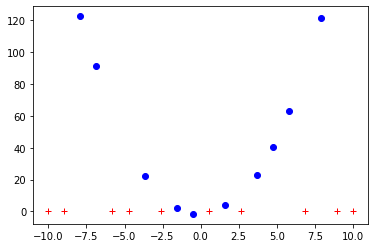

In [5]:
plt.plot(train_ftr, train_tgt, 'bo')
plt.plot(test_ftr, np.zeros_like(test_ftr), 'r+')

The numbers are a straightforward example of a regression task. Let's pull out linear regression (LR) and see what happens.

In [6]:
# note: sklearn *really* wants 2D inputs (a table)
# so we use reshape here.
sk_model = linear_model.LinearRegression()
sk_model.fit(train_ftr.reshape(-1, 1), train_tgt)
sk_preds = sk_model.predict(test_ftr.reshape(-1, 1))
sk_preds[:3]

array([53.218 , 41.4552, 56.8374])

### 5.3.2 Manually Manipulating Model Complexity

Numpy provides `polyfit`, which takes input and output values, our features and a target, and a *degree of polynomial* to align with the data. Then, it figures out the right knob values--the coefficients of polynomails--and using `np.poly1d` turns the coefficients into a function that can take inputs and produce outputs. Let's explore how it works.

In [7]:
# fit-predict-evaluate a 1D polynomial (a line)
model_one = np.poly1d(np.polyfit(train_ftr, train_tgt, 1))
preds_one = model_one(test_ftr)
print(preds_one[:3])

[53.218  41.4552 56.8374]


Interesting. The first three preds are the same as our LR model. Are all the predictions from these inputs the same? Yes. Let's demonstrate that and calculate the RMSE of the model:

In [8]:
# the preds come back the same
print('all close?', np.allclose(sk_preds, preds_one))

# and we can still use sklearn to evaluate it
mse = metrics.mean_squared_error
print('RMSE:', np.sqrt(mse(test_tgt, preds_one)))

all close? True
RMSE: 86.69151817350722


Two take-home messages here. You can use alternative systems to train models. Not just `sklearn`. You can even use those alternative systems *with* `sklearn` to do the evaluatoin. Message 2: `np.polyfit`, can be manipulated to produce any degree of polynomial we are interested in. We just have to fit a relatively simple line, but we can move beyond that to more complicated patterns. Let's explore that now.

One way to manipulate the complexity of linear regression is to ask, "What happens if we break out of our straight jacket and allow bends?" We can start answering that by looking at what happens when we add a single bend. For the non-mathphobic, a curve with one bend in it--called a parabola--is described by a degree-two polynomial. Instead of fitting a straight line to the points and picking the line with the lowest squared error, we hold up parabolas, curves with a single bend, to the training data and find the one that fits best. The mathematics are surprisingly, or at least comfortingly, similar. As a result, our code only requires a minor tweak.

In [9]:
# pit-predict-evaluate a 2dpolynomial (a parabola)
model_two = np.poly1d(np.polyfit(train_ftr, train_tgt, 2))
preds_two = model_two(test_ftr)
print('RMSE:', np.sqrt(mse(test_tgt, preds_two)))

RMSE: 1.2765992188881143


The test error improved quite a bit. Let's increase it again, this time using a degree-9 polynomial, also known as a *nonic*.

In [10]:
model_three = np.poly1d(np.polyfit(train_ftr, train_tgt, 9))
preds_three = model_three(test_ftr)
print('RMSE:', np.sqrt(mse(test_tgt, preds_three)))

RMSE: 317.36344242352277


The error is significantly worse than we saw with the parabola. That could be unexpected. Let's investigate.

### 5.3.3 Goldilocks: Visualizing Overfitting, Underfitting, and "Just Right"

The error got terribly worse. What wen wrong? Let's break down what happened in the training and testing data visually.

In [11]:
import matplotlib.pyplot as plt

labels = ['line', 'parabola', 'nonic']
models = [model_one, model_two, model_three]
train = (train_ftr, train_tgt)
test = (test_ftr, test_tgt)
print(labels)
print(models)
print(train)
print(test)

['line', 'parabola', 'nonic']
[poly1d([-0.8596, 49.1463]), poly1d([ 1.9989, -0.0705, -3.0422]), poly1d([ 0.    , -0.    , -0.0005,  0.0008,  0.0187, -0.0232, -0.237 ,
        1.9887,  0.9495, -1.6969])]
(array([-1.5789, -6.8421, -3.6842,  1.5789, -7.8947,  3.6842,  7.8947,
        4.7368,  5.7895, -0.5263]), array([  2.3906,  91.0234,  22.3791,   3.8658, 122.5817,  22.9962,
       121.7528,  40.6026,  62.7696,  -1.6137]))
(array([ -4.7368,   8.9474,  -8.9474,  -2.6316, -10.    ,   0.5263,
         2.6316,  10.    ,  -5.7895,   6.8421]), array([ 40.4993, 156.8386, 158.9137,  12.3151, 196.4982,  -4.3636,
        12.1802, 196.1649,  62.6601,  89.8458]))


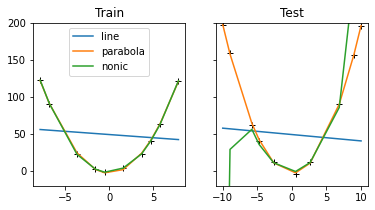

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
for ax, (ftr, tgt) in zip(axes, [train, test]):
    ax.plot(ftr, tgt, 'k+')
    for m, lbl in zip(models, labels):
        ftr = sorted(ftr)
        ax.plot(ftr, m(ftr), '-', label=lbl)

axes[1].set_ylim(-20, 200)
axes[0].set_title('Train')
axes[1].set_title('Test')
axes[0].legend(loc='upper center')

model_one, the straight line, has difficulty because our model follows a curved trajectory. `model_two` follows the curve just perfectly. `model_three` *seems* to follow the curve wonderfully when we train. It overlaps both `model_two` and the real outputs. However, it has problems when we go to testing. It starts exploding out of control near `ftr=-7`

Let's run the model and gather up the results in one table. LEt's also throw in a degree-6 model.

In [13]:
results = []
for complexity in [1, 2, 6, 9]:
    model = np.poly1d(np.polyfit(train_ftr, train_tgt, complexity))
    train_error = np.sqrt(mse(train_tgt, model(train_ftr)))
    test_error = np.sqrt(mse(test_tgt, model(test_ftr)))
    results.append((complexity, train_error, test_error))
columns = ['Complexity', 'Train Error', 'Test Error']
results_df = pd.DataFrame.from_records(results,
                                       columns=columns,
                                       index='Complexity')
results_df

,Train Error,Test Error
Complexity,,
1,45.4951,86.6915
2,1.0828,1.2766
6,0.2819,6.1417
9,0.0000,317.3634


* Model one (Complexity 1-a straight line): The model does not have enough raw horsepower, or capacity, to capture the complexity of a target. It is too biased towards flatness. The model *underfits*
* Model three (Complexity 9-a wiggly 9-degree polynomial): Has enough horsepower. It is perfect on the training data but falls apart on the testing data because it memorized the *noise* or the randomness in the data. It veries too much with the data, meaning it *overfits* the data.
* Model two (complexity 2-a parabola). It's not too hot, it's not too cold, it's just right, like Goldilocks. We do well on both the testing and training data. If we had set up a full validation step to select between the three machines with different complexity, we would be quite happy with model two. 

Let's graph the results of the train and test sets.

<AxesSubplot:xlabel='Complexity'>

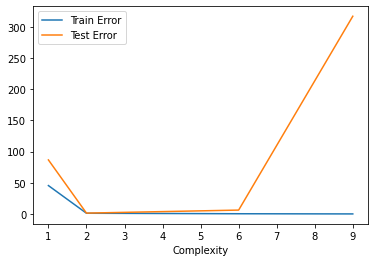

In [14]:
results_df.plot()

The key take-away is that as we ratchet up the complexity of the model, we get to a point where we can make the training error very small but where it really counts, on the test set, we get worse. Then, we get terrible. To highlight the important pieces of the graph, we can see a version with helpful labels.

<img src="graphs.jpg" alt="graphs" style="width: 800px;"/>

### 5.3.4 Simplicity

## 5.4 From Errors to Costs

When discussing over and underfitting, we compared model complexity and model error rates. As we vary the complexity of models, the degree of polynomials, we have different training and test performance. Error and Complexity are intimately tied together. Some methods can explicitly trade off training error for complexity.

In the factory machine analogy, we consider *both* our success in copying the input-output relationship *and* the values we set on the knobs. By separating out these two aspects of "model goddness" we can speak generally about both regression and classification problems. After progressing more, we'll be able to *describe* many algorithms in terms of just a few choices. How a method treats errors and complexity are two of these choices.

### 5.4.1 Loss

We construct a *loss function* that quantifies what happens when our model is wrong on a single example. We use that to build a *training loss* function that measures how well the model does on the entire training set. More technical write-ups call this the *empirical loss.* The training loss is the sum of the losses on each example. We can write that in code as the following:
    

In [15]:
def training_loss(loss, model, training_data):
    ' total training_loss on train_data with model under loss'
    return sum(loss(model.predict(x.reshape(1, -1)), y)
                                  for x, y in training_data)

def squared_error(prediction, actual):
    ' squared error on a single example'
    return (prediction - actual)**2

# could be used like:
# my_training_loss = training_loss(squared_error, model, training_data)

A generic mathematic way to write this is:

$$ TrainingLoss_{Loss}(m, D_{train}) = \Sigma_{x,y \in D_{train}} Loss(m(x),y) $$

where m represents the model.  In the specific case of squared-error (SE) on 3-NN, where 3-NN(x) represents the prediction of 3-NN on an example *x*:

$$ TrainingLoss_{SE}(\text{3-NN}, D_{train}) = \Sigma_{x,y \in D_{train}} SE(\text{3-NN}(x), y) = \Sigma_{x,y \in D_{train}} (\text{3-NN}(x) - y)^2 $$ 

We put this into code in the following example.

In [16]:
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
fit = knn.fit(diabetes.data, diabetes.target)

training_data = zip(diabetes.data, diabetes.target)

my_training_loss = training_loss(squared_error, knn, training_data)
print(my_training_loss)

[863792.3333]


We can use `sklearn`'s `mean_squared_error` and multiply it by the number of training examples to undo the `mean` part to get the same answer.

In [17]:
mse = metrics.mean_squared_error(diabetes.target,
                                 knn.predict(diabetes.data))
print(mse*len(diabetes.data))

863792.3333333333


The TrainingLoss equation is a fundamental principle underlying the evaluation calculations we use. We add on to the equation to deal with the problem of determining a good model complexity. 

### 5.4.2 Cost

We can capture *any* pattern, even patterns that are noise. We need something that works against complexity and rewards simplicity. We do that by adding a value to the training loss to create a total notion of *cost*. $ cost = loss + complexity $. The term we add to deal with complexity has several technical names: regularization, smoothing, penalization, or shrinkage. 

The total cost we pay to use a model on some data depends on (1) how well it does and (2) how complicated it is. Complexity is like a baseline investment. With a very high initial investment, we better not have many errors. If we have a low initial investment, we might have some room to allow for error. The term for performance on unseen data is *generalization*. 

There is not a fixed idea how to trade off error and complexity. We leave it as an open question and it becomes part of the way our machine is build. It's another hyperparameter. Using the traditional naming scheme, lambda represents that tradeoff between error and complexity: $ \lambda $.

It can be unnatural to phrase some learners strictly in terms of loss and complexity, it is very broadly possible. We can choose a good value of $ \lambda $ by performing several rounds of validation testing and taking the $ \lambda $ that leads to the lowest cost.

In [18]:
def complexity(model):
    return model.complexity

def cost(model, training_data, loss, _lambda):
    return training_loss(model, training_data) + _lambda * complexity(model)

Mathematically, this looks like 

$$ Cost(m, D_{train}, Loss, \lambda) = TrainingLoss_{Loss}(m, D_{train}) + \lambda \times Complexity(m) $$

In other words, our cost goes up (1) if we make more mistakes and (2) if we invest resources in more expensive, but also more flexible models. If we take $ \lambda = 2 $, one unit of complexity is comparable to two units of loss. If we take $ \lambda = .5 $, two units of complexity are comparable to one unit of loss. Shifting $ \lambda $ adjusts how much we care about errors and complexity.

### 5.4.3 Score

* Score: higher is better, try to maximize
* Loss, error, and cost: lower is better, try to minimize.


## 5.5 (Re)Sampling: Making More from Less

How can we turn one dataset into many?

### 5.5.1 Cross-Validation

<img src="buckets.jpg" alt="buckets" style="width: 800px;"/>

**Figure 5.5** The setup for CV splits the data into approximately equal buckets.

Now, let's take the following setps as shown in the figure below:

1. Take bucket $B_{1}$, combine $B_{II}$ and $B_{III}$ and use them as our training set. Train *ModelOne* from the combined training set. Now, evaluate *ModelOne* on bucket $B_{1}$ and record the performance as *EvalOne*.

<img src="CV.jpg" alt="cross-validation" style="width: 800px;"/>

After recording the three performance values, we may wish to graph them or summarize them statistically. 

Let's look at 5-fold CV with `sklearn`.

In [19]:
# data, model, fit & cv-score
model = neighbors.KNeighborsRegressor(10)
skms.cross_val_score(model,
                     diabetes.data,
                     diabetes.target,
                     cv=5,
                     scoring='neg_mean_squared_error')

# notes:
# defaults for cross_val_score are
# cv=3 fold, no shuffle, stratified if classifier
# model.score by default (regressors: r2, classifiers: accuracy)

array([-3206.7542, -3426.4313, -3587.9422, -3039.4944, -3282.6016])

The default value for the `cv` argument to `cross_val_score` is `None`. To understand what that means, we have to look into the documentation for `cross_val_score`. 

`cv`: int or None or others. Determines the cross-validation splitting strategy. Possible inputs for cv are:
* None, to use the default 3-fold cross validaiton
* Integer, to specify the number of folds in a `(Stratified)K`
* Others

For integer/None inputs, if the estimator is a classifier and `y` is either binary or multiclass, `StratifiedKFold` is used. In all other cases, `KFold` is used.

Two take home lessons:

* By default we're doing 3-fold CV
* for classification problems, `sklearn` uses stratification.

By using `scoring='neg_mean_squared_error`, `sklearn` negates the MSE to go from an error measure to a score. Scores are all *negative*, but a bigger score is better. We can think of it as losing less money: instead of being down $100, we are down only $7.50.

The default scoring for regressors is `r2`, also known as the *coefficient of determination*. It is very easy to misuse $R^2$ in `sklearn`.

Using *k*-CV we need to balance three things. 

1. How long does it take to train and test our models. A bigger *k* means more bucks, which, in turn means more training and testing phases.
    1. Some incremental/decremental learning methods can be implemented to minimize the amount of work necessary to train and test different models.
    2. Most common models are *not* implemented with CV routines in a way that allows for this efficiency. 
    3. Training on smaller datasets is *faster* than training on larger datasets.
    4. The run times depend on the specific learning methods.
2. The second issue to balance is the value of *k* slides up and down betwen two extremes. The smallest useful value is *k* = 2, which makes two buckets of data and two estimates of our test error. 
    1. The largest value of *k* takes in the number of data points we have, $k = n$, resulting in each sample being in its own bucket and *n* total models and estimates. 
    2. When we have two buckets, we never train on the same data.
    3. With three buckets, we have some overlap--half the training set used to create the model tested $B_1$ is in common with the training sets used to create the model tested on $B_{II}$. The common elements are those in $B_{III}$. 
    4. With *n* buckets, between any two of our models, they are trained on the *same n - 2* examples (see the figure below).
    5. To get the full *n* examples, there's one more example for training that is different in the two CV folds and another example that is reserved for testing.
  
<img src="overlap.JPG" alt="overlap" style="width: 800px;"/>

The net effect is that the data in the training folds for $ k = 2 $ is *very different* and the data in the training folds for $ k = n $ is *almost the same.* The estimates we get out of $k = 2$ will be quite different, if there is a difference to be found. The estimates out of $k = n$ will be similar because they are doing *almost* the same thing!

The theird issue is that small values of *k* relatively few folds, will result in training set sizes ranging from 50% (k=2) to 90% (k=10) of the data. Whether learning on that much data will be sufficient depends on the problem at hand. We can evalute that graphically using learning curves, as in Seciton 5.7.1 If the learning curve flattens out at the percent of data we are trying to learn from--if that much data is enough to get us to a sufficient performance threshold--we are probably OK using the related number of folds.

### 5.5.2 Stratification

Let's turn to a quick example of cross-validation in a classification context. Here, we tell `cross_val_score` to use 5-fold CV.

In [20]:
iris = datasets.load_iris()
model = neighbors.KNeighborsClassifier(10)
skms.cross_val_score(model, iris.data, iris.target, cv=5)

array([0.9667, 1.    , 1.    , 0.9333, 1.    ])

The cross-validation is done in a *stratified* manner because it is the default for classifiers in `sklearn`. Stratification means that when making our trianing-testing splits for cross-validation, we want to respect the proportions of the targets that are present in our data. Let's look at an example from a small dataset targeting cats and dogs that we'll take two-fold training samples form.

In [21]:
# not stratified 
pet = np.array(['cat', 'dog', 'cat',
                'dog', 'dog', 'dog'])
list_folds = list(skms.KFold(2).split(pet))
print(list_folds)

[(array([3, 4, 5]), array([0, 1, 2])), (array([0, 1, 2]), array([3, 4, 5]))]


In [22]:
training_idxs = np.array(list_folds)[:, 0, :]
print(training_idxs)
print(pet[training_idxs])

[[3 4 5]
 [0 1 2]]
[['dog' 'dog' 'dog']
 ['cat' 'dog' 'cat']]


There are no `cat`s in the first fold. There's not great. If that were our target, we would have no examples to learn about cats. Stratified sampling enforces fair play among the cats and dogs:

In [23]:
# stratified
# note: typically this is behind the scenes
# making StratifiedKFold produce readable output
# requires some trickery.
pet = np.array(['cat', 'dog', 'cat', 'dog', 'dog', 'dog'])
idxs = np.array(list(skms.StratifiedKFold(2)
                         .split(np.ones_like(pet), pet)))
training_idxs = idxs[:, 0, :]
print(pet[training_idxs])

[['cat' 'dog' 'dog']
 ['cat' 'dog' 'dog']]


Now, both folds have a balanced number of cats and dogs, equal to their proportion in the overall dataset, ensuring we have the same *percent* of dogs and cats in each of our training sets as we do in our entire, available population. Without stratification, we could end up having too few (or even none) of a target class--in our nonstratified example, the first training set had no cats. That training data will not lead to a good model.

Stratification is useful when (1) we have limited data overall or (2) we ahve classes that are poorly represented in our dataset. Poor representation might be due to rareness, if we are talking about an uncommon disease or winning lottery tickets, or it might be due to our data collection processes. Having a limited total amount of data makes *everything* rare, in a sense.

How does the default stratification apply to the *iris* dataset in Chapter 3? It means that when we perform the CV splits, we can be sure that each of the training sets has a balanced representation from each of the three possible target flowers. IF we don't want stratification, it's slightly more tricky, but we can do it.

In [24]:
# running nonstratified CV
iris = datasets.load_iris()
model = neighbors.KNeighborsClassifier(10)
non_strat_kf = skms.KFold(5)
skms.cross_val_score(model,
                     iris.data,
                     iris.target,
                     cv=non_strat_kf)

array([1.    , 1.    , 0.8667, 0.9667, 0.7667])

We can guess that the last fold probably had a bad distribution of flowers. We probably didn't see enough of one species to learn patterns to identify it.

### 5.5.3 Repeated Train-Test Splits

Now, we will do some repeated coin flipping to generate several train-test splits. Why do we want to *repeat* the fundamental train-test split step? Any time we rely on randomness, we are subject to variation: several different train-test splits might give different results. Some will turn out well and others bad. Regarding train-test splits, we don't know ahead of time how well we expect to perform. If the problem is easy, all of the train-test splits will give a good learner that performs well on the test set. If it is a hard problem and we happen to select an easy subset of training data, we do great in training but perform horribly in testing. We can investigate the variation due to the train-test split by making many train-test splits and looking at different resutls. 

We do this by randomly resplitting several times and evaluating the outcomes. We can even compute stats, the mean, median, or variance, of the results if we want to get technical. The multiple values-one per train-test split- get us a distribution of the results and how often they occur. Repeated train-test splits get us a distribution of our evaluation measure, whether it is accuracy, root-mean-squared-error, or something else. The distribution is *not* over *every* possible source of variation. It simply takes into account one difference due to randomness: how we picked the training and testing data. We can see how *variable* our result is *due to* the randomness of mkaing a train-test split. Let's look at some results.

In [25]:
# As a reminder, these are some of the imports 
# that are hidden behind: from mlwpy import *
# from sklearn import (datasets, neighbors,
#                      model_selection as skms,
#                      linear_model, metrics)
# see Appendix A for details

linreg = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

scores = []
for r in range(10):
    tts = skms.train_test_split(diabetes.data,
                                diabetes.target,
                                test_size=.25)
    (diabetes_train_ftrs, diabetes_test_ftrs,
     diabetes_train_tgt, diabetes_test_tgt) = tts
    
    fit = linreg.fit(diabetes_train_ftrs, diabetes_train_tgt)
    preds = fit.predict(diabetes_test_ftrs)
    
    score = metrics.mean_squared_error(diabetes_test_tgt, preds)
    scores.append(score)
    
scores = pd.Series(np.sqrt(sorted(scores)))
df = pd.DataFrame({'RMSE':scores})
df.index.name = 'Repeat'
display(df.T)


Repeat,0,1,2,3,4,5,6,7,8,9
RMSE,49.0032,50.1912,51.9735,52.0722,53.2005,55.7008,56.2542,57.4917,58.6379,58.6942


Let's make a plot `swarmplot`, from the Seaborn library. It makes a single value plot--also called a stripplot--and stacks repeated values horizontally so you get a feel for where there are clumps of values.

Text(0.5, 0, 'Over Repeated\nTrain-Test Splits')

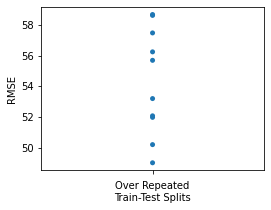

In [26]:
ax = plt.figure(figsize=(4, 3)).gca()
sns.swarmplot(y='RMSE', data=df, ax=ax)
ax.set_xlabel('Over Repeated\nTrain-Test Splits')

In [27]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
RMSE,10.0000,54.3219,3.5058,49.0032,51.9982,54.4507,57.1823,58.6942


When evaluating plots like this, always orient yourself to the scale of the data. We might think the data is pretty spread out, but upohn further review, we see it is clustered in the mid-to-upper 50s. Whether that is a lot depends on the size of the RMSE values--the mean is near 55, so we are in the ballpark of $ \pm10%$. That's large enough to warrant our attention.

Here's a way we can rewrite the score-computing code above with a list comprehension instead of a loop. The basic strategy is to (1) take the contents of the loop and turn it into a function and (2) use that function repeatedly in a list comprehension. The rewrite gets us a bit of performance gain. The biggest win is that we've given a *name* to our process of making a train-test split, fitting, predicting, and evaluating. Defining a function also gives us a single entity taht we can test for resource use and *reuse* in other code.

In [28]:
def tts_fit_score(model, data, msr, test_size=.25):
    'apply a train-test split to fit model on data and eval with MSR '
    tts = skms.train_test_split(data.data,
                                data.target,
                                test_size=test_size)
    (train_ftrs, test_ftrs, train_tgt, test_tgt) = tts
    fit = linreg.fit(train_ftrs, train_tgt)
    preds = fit.predict(test_ftrs)
    
    score = msr(test_tgt, preds)
    return score

linreg = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()
scores = [tts_fit_score(linreg, diabetes,
                        metrics.mean_squared_error) for i in range(10)]

print(np.mean(scores))

3052.5402730578844


With *k*-CV, we will get one, and only one, prediction for each and every example. Each example is in precisely one test bucket. The predictions for the *whole* dataset will be aggregated from the *k* models that are developed on different sets of data. With repeated train_test splits, we may completely ignore training or predicting on some examples and make repeated predictions on other examples as we see in the figure below. In repeated train-test splits, it is all subject too the randomness of our selection process.

<img src="RTTS.jpg" alt="RTTS" style="width: 800px;"/>

**Figure 5.8** RTTS may have duplication between repeats

### 5.5.4 A Better Way and Shuffling

Managing the repeated looping to make multiple train-test splits was a bit annoy. It was not heart- or back-breaking, but there are many places we could make a mistake. It would be nice if someone wrapped the process up in a single stand-alone function. Fortunately, `sklearn` has done that. If we passa in a `ShuffleSplit` data-splitter to the `cv` argument of `cross_val_score`, we get precisely the algorithm we hand-coded above.

,count,mean,std,min,25%,50%,75%,max
RMSE,10.0000,55.4388,3.5870,50.1900,52.9660,55.3967,58.3911,60.5432


Text(0.5, 0, 'Over Repeated\nTrain-Test Splits')

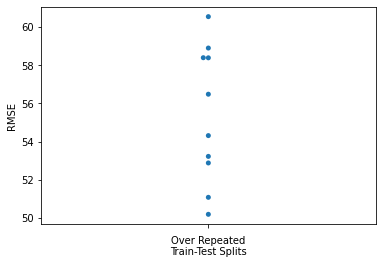

In [29]:
linreg   = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

# nondefault cv=argument
ss     = skms.ShuffleSplit(test_size=.25) # default, 10 splits
scores = skms.cross_val_score(linreg,
                               diabetes.data, diabetes.target,
                               cv=ss,
                               scoring='neg_mean_squared_error')

scores = pd.Series(np.sqrt(-scores))
df     = pd.DataFrame({'RMSE':scores})
df.index.name = 'Repeat'
display(df.describe().T)

ax = sns.swarmplot(y='RMSE', data=df)
ax.set_xlabel('Over Repeated\nTrain-Test Splits')

The slight differences with our manual version are due to randomly selecting the train-test splits. Now, we will talk about the randomness that goes on behind the scenes with `ShuffleSplit` and the `random_state` momentarily.

In [30]:
ss = skms.ShuffleSplit(test_size=.25, random_state=42)

train, test = 0, 1
next(ss.split(diabetes.data))[train][:10]

array([ 16, 408, 432, 316,   3,  18, 355,  60, 398, 124])

We use `next` because `ShuffleSplit` relies on a Python generator to produce one split after another. `next` provides us with the next data split. After fetching the next data split, pick out the training data `[train]` and then the first ten examples `[:10]`.

In [31]:
ss = skms.ShuffleSplit(test_size=.25, random_state=42)
next(ss.split(diabetes.data))[train][:10]

array([ 16, 408, 432, 316,   3,  18, 355,  60, 398, 124])

Randomness on a computer is pseudo-random, being that it's a long list of numbers are random enough to fake their randomness. The values we generate will *look* mostly random, but the process used to generate them is deterministic. If we specify a starting point for the sequence of pseudo-random numbers, we get a reproducible list of the not-so-random values.

When we use `random_state`, we set a starting point for `ShuffleSplit` to use when it asks for randomness. Repeatable train-test splitting is useful for creating reproducible test cases, sharing examples with students, and eliminating degrees of freedom when chasing down bugs.

Here's another place a similar issue compes up. Let's do two separate runs of `KFold`ing.

In [32]:
train, test = 0, 1
print(f'Train: {train}\nTest:  {test}')
kf = skms.KFold(5)
print(kf)
print(next(kf.split(diabetes.data))[train])
next(kf.split(diabetes.data))[train][:10]

Train: 0
Test:  1
KFold(n_splits=5, random_state=None, shuffle=False)
[ 89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 3

array([89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [33]:
kf = skms.KFold(5)
next(kf.split(diabetes.data))[train][:10]

array([89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [34]:
kf = skms.KFold(5)
next(kf.split(diabetes.data))[train][:10]

array([89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

The lack of randomness, in places we *want* randomness, is starting to get a little old. The issue here is the default parameters to `KFold`.

```python
skms.KFold(n_splits=3, shuffle=False, random_state=None)
```

`shuffle=False`, the default, means that we *don't* shake up the examples before distributing them to different folds. If we *want* them shaken up, we need to say so. To keep the examples more readable, we switch back to the simple `pet` targets.

#### 5.5.4.1 sklearn.model_selection.KFold
```python
class sklearn.model_selection.KFold(n_splits=5, *, shuffle=False, random_state=None)

from sklearn import model_selection

split(x, y=None, groups=None)
```
The `split()` method generates indices to split data into training and test sets. It yields a train: *ndarray* and an test: *ndarray*. 

In [35]:
pet = np.array(['cat', 'dog', 'cat',
                'dog', 'dog', 'dog'])

kf = skms.KFold(3, shuffle=True)

train, test = 0, 1
split_1_group_1 = next(kf.split(pet))[train]
split_2_group_1 = next(kf.split(pet))[train]

print(f'Pet: {pet}')

print(f'kf: {kf}')
print(f'kf: {kf.get_n_splits()}')

print(f'Split group 1: {split_1_group_1}')
print(f'Split group 2: {split_2_group_1}')

print(f'Split group 1: {pet[split_1_group_1]}')
print(f'Split group 2: {pet[split_2_group_1]}')

Pet: ['cat' 'dog' 'cat' 'dog' 'dog' 'dog']
kf: KFold(n_splits=3, random_state=None, shuffle=True)
kf: 3
Split group 1: [0 1 4 5]
Split group 2: [0 1 3 5]
Split group 1: ['cat' 'dog' 'dog' 'dog']
Split group 2: ['cat' 'dog' 'dog' 'dog']


If we set a random state, it's shared by the splitters.

In [36]:
kf = skms.KFold(3, shuffle=True, random_state=2)

split_1_group_1 = next(kf.split(pet))[train]
split_2_group_1 = next(kf.split(pet))[train]
print(split_1_group_1,
      split_2_group_1)

[0 2 3 5] [0 2 3 5]


# 5.5.5 Leave-One-Out Cross-Validation

With 20 training examples, we could potentially make 20 train-test splits, do 20 training fits, do 20 testing rounds, and get 20 resulting evaluations. This version of CV is called *leave-one-out cross-validation* (LOOCV) it is interesting because *all* of the models we generate are going to have *almost all* of their training data in common. 

With 20 examples, 90% of the data is shared between any two training runs. You can refer back to Figure 5.7 to see it visually.

from sklearn.linear_model import LinearRegression

,count,mean,std,min,25%,50%,75%,max
RMSE,442.0000,44.3557,32.1973,0.2075,18.4820,39.5472,63.9738,158.2355


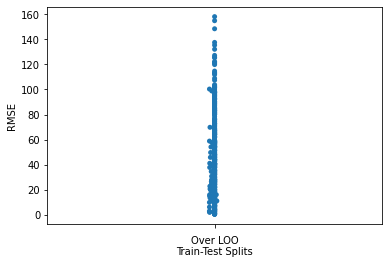

In [37]:
linreg = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

loo = skms.LeaveOneOut()
scores = skms.cross_val_score(linreg,
                              diabetes.data, diabetes.target,
                              cv=loo,
                              scoring='neg_mean_squared_error')
scores = pd.Series(np.sqrt(-scores))
df = pd.DataFrame({'RMSE':scores})
df.index.name = 'Repeat'

display(df.describe().T)
ax = sns.swarmplot(y='RMSE', data=df)
ax.set_xlabel('Over LOO\nTrain-Test Splits')
plt.show()

In [38]:
print(f'diabetes dataset length: {len(diabetes.data)}')

diabetes dataset length: 442


Curiously, about three noticeable points have a high RMSE and about twenty points form a distinct peak about the main body of the errors (RMSE > 100). There are about twenty points that are resistant to prediction with the model we are building using almost all of the data. It would be worthwhile to investigate any common factors in those difficult examples.

LOOCV is a deterministic evaluation method, which means there's no randomness in the selection because everything is used in the save way every time we runm LOOCV. This can be useful for comparing and testing correctness of learning algorithms. It can be expensive to run LOOCV because we need to train the model once for each left-out example.

The net effect on the evaluatoin side of incorporating lots of training data in every CV partition is that LOOCV gives a relatively unbiased estimate of the real error rate. Because the single-example predictions are so closely related and most of the training data is shared and piped into the same learning algorithm--the estimates of our performance error on *new* examlpes can vary widely. Overall, a general recommendation is to prefer 5- or 10-fold CV to LOOCV.

## 5.6 Break-It-Down: Deconstructing Error into Bias and Variance

### 5.6.1 Variance of the Data

---

1. When we have an incorrect class or a MSE greater than zero, in other words when we make a mistake, there may be a few different causes. One of the causes is actual randomness in the relatoinship betwen the input features and the output target, we have no real control over.
    1. College graduates that majored in economics and have five years of professional work experience will earn different amounts of money.
    2. In the race track example, randomness may occur due to our timing devices or user error.
   
1. Having a rnage of outputs is a fundamental difference between the mathematical functions you saw in high school and random processes. 
    1. Instead of a single input having one-and-only-one output, a single input can have a distribution or a range of outputs. 
    2. Therefore, the degree to which our data is affected by randomness--either in measurement or in real-world differences--is called the *variance of the data*.
    
### 5.6.2 Variance of the Model

---

1. There are some sources of error we *can* control in a learning system, though there are limits on our control.
    1. When we choose our training and testing datasets at random in a machine learning model, we lose some control over the outcome. 
        1. Therefore, model parameters are subject to the coin-flipping choice o training data.
        2. Flipping the coins again gives us different training data.
        3. Different training data gives us a different trained model.
        4. The *variance of the model* is the way models vary due to the random selection of the data we train on.
2. If we have a very bad data point, with a 1-NN model, most training and testing examples are unaffected by it.
    1. However, for anyone that *is* the nearest neighbor of the bad example, things will go wrong.
    2. If, however, we used a large number of neighbors, the effect of that example would be diluted out among many other training examples.
        3. We have a tradeoff: being able to account for tricky examlpes also leaves us exposed to following bad examples.

### 5.6.3 Bias of the Model

---

1. The last source of error is where we have the most control, the bias of the model.
    1. As an example, a line has great difficulty following the path of a parabola.
2. We can eliminate the noise, or the inherent randomness, by considering only a best-guess output for any given input.
    1. A model that cannot match the *actual* relationship between the inputs and outputs, after ignoring the inherent noisiness in the data--has higher *bias*.
        1. Highly biased models have difficulty capturing complicated patterns.
        2. Models with low bias can follow more complicated patterns.

### 5.6.4 All Together Now

---

1. Together, these three components give us a fundamental breakdown of the sources of errors in our predictions.
    1. The variability in our data
    2. the variability in creating our predicting model from training data
    3. the bias of our model.
        1. The relationship between these and our overall error is called the *bias-variance decomposition* written mathematically as $$ Error = Bias_{Learner} + Variance_{Learner(Training)} + Variance_{Data} $$
        2. The errors in our predictions are due to the randomness in the data, variability in building our model from training data, and the difference between the relatoinships our model can express and the actual, *true* relationship in the data.

### 5.6.5 Examples of Bias-Variance Tradeoffs

---

We will look at some concrete examples of the bias-variance tradeoff by looking at how it applies to *k*-Nearest Neighbors, Linear Regression, and Naive Bayes.

#### 5.6.5.1 Bias-Variance for *k*-NN

---

Let's consider what happens when we vary the number of neighbors in *k*-NN models to the extreme. 

1. The fewest number of neighbors we can choose is one, which amounts to saying, "If I am a new example, find who is most like me and label me with their target."
    1. 1-NN has the potential to have a very jagged or wiggly board.
    2. Every training examples gets to have its own say without consulting any of else.
        1. Once we find the cloest example, we ignore what anyone else says.
        2. With ten training examples, once we choose a closest neighbor, nothing about the other nine matters.
2. When we do the opposite and do a 10-NN when we have ten examples, the strategy becomes to find the ten closest neighbors of a new example and average their target.
    1. With 10 total example, every new example we come across has the exact same ten nearest neighbors.
    2. Therefore, no matter the example, we are averaging *everyone's* target value.
        1. This is equivalent to saying "Make my predicted value the overall training mean."
        2. Here, are predictions have no border, they are all exactly the same.
            1. In other words, we predict the same value regardless of the input predictor values.
            2. The only more biased prediciotn would be predicting some constant--say, 50--that isn't computed from the data at all.
3. Decreasing ⬇ the number of neighbors increases ⬆ our variance and decreases ⬇ our bias (the model makes separate predictions for each training example because they are not average across all of the same NNs for each new test example).
4. Increasing ⬆ the number of neighbors decreases ⬇ our variance and increases ⬆ our bias (all the predictions are the same)
<img src="bias-variance.jpg" alt="bias-variance" style="width: 800px;"/>

**Figure x** Bias in *k*-NN

#### 5.6.5.2 Bias-Variance for Linear Regression

---

1. Consider two linear regression models, *ConstantLinear* predicts a flat horizontal line and *PlainLinear* is a standard line that can incline and tilt.
    1. *ConstantLinear* - sets all weights except $ w_0 $ to zero and gives the same output value regardless of input.
        1. High bias
        2. Low Variance
    2. Few: include a few features, most $ w_i = 0 $
    3. Many: include many features, a few $ w_i = 0 $ 
    4. *PlainLinear* - include all features, no $ w_i = 0 $
        1. Low bias
        2. High Variance
2. With these variations, we have a spectrum of complexitities for our linear regression model as we saw with *k*-NN.
    1. By setting more weights to zero and including fewer features, we cannot distinguish between differences represented in the lost features.
        1. Our model gets *flatter* with respect to the missing dimensions.
    <br><img src="shadow.jpg" alt="shadow" style="width: 800px;"/>
    2. By *extending* the features we include, such as by adding more *polynomial* terms like $x^2 and x^3$ we can accomodate more bends or wiggles in our data.
        1. We use these bends to capture examples that appear to be oddities.
        2. This also means we can be fooled by noise.
    <br><img src="extend.jpg" alt="extend" style="width: 800px;"/>
    3. In linear regression, adding features, such as polynomial terms, decreases bias but increases variance. On the other hand, forcing the weights of features to zero increases bias and decreases variances.

#### 5.6.5.3 Relating *k*-NN and Linear Regression

---

1. The most biased linear regression and nearest-neighbors models *both predict the mean*.
    1. The constant linear model predicts a single value everywhere: *the mean*.
    2. a *k*-NN system that has *k* equal to the number of examples in the training dataset takes into account all of the data and summarizies it, and this summary can be the *mean*.
2. On the other end of the spectrum, the end with less bias, we get complexity in two very different ways.
    1. *PlainLinear* includes information from all features, but trades off feature values, based on parameter weights, to get a "central" predicted value.
    2. *1*-NN includes information from all the *features* in the distance calculation, but it only considers the closest *example* to get the prediction value.
3. Consulting *more examples* in nearest neighbors leads to *more bias*, yet consulting *more features* in linear regression leads to *less bias*.
    1. The explanation is that in nearest neighbors, when we consult someone else, we average the differences between examples.
    2. Therefore, this has as much to do with our method of aggregating the informatoin as it does with the fact that we are consulting more examples.

#### 5.6.5.4 Bias-Variance for Naive Bayes

---

What is the bias-variance of NB? Describing the tradeoff with NB is a little different because Naive Bayes is more like a single point on a spectrum of assumptions. 

1. The spectrum that NB lives on has *the number of conditional independence assumptions* on its *x* axis for complexity. 
    1. NB makes almost as many of these as possible: everything is conditionally independent given the class.
        <br><img src="NB.jpg" alt="NB" style="width: 800px;"/>
    2. If a class is independent of all features, which we could describe as the ultimate independence assumption, the best we can do is guess based on the class distribution.
       1. For a continuous target, this implies that we guess the *mean*.
    3. Other, more complicated models that try to add complexity to NB could make fewer and fewer independence assumptions.
       1. These models would come with more and more complicated claims about dependency.
       2. Eventually we get the most complicated type fo dependency, the dreaded *full joint distribution.* 
           1. If we want to adequatly capture the distincitions in a fully dependent joint distribution, we need an amount of data that is exponentional in the number of features of the data.
           2. For each additional feature we need something like another factor-of-10 examples.
           3. If we need 100 examples for two features, we need 1000 for three features and so forth.

#### 5.6.5.5 Summary Table

---

Each learning method, motivated by different priorities and data conceptualizations, all have a common starting point: in a simple enough scenario, they all predict the *mean*. Nearest neighbors with every example predicts the mean, if we choose it as our summary calculation. Linear regression with only $w_0$? The $w_0$ is the mean. A simpler form of Naive Bayes, is exactly the mean, or the most frequent value for a classification problem of the output target.

However, each method extends that in different ways.

| Scenario | Example | Good | Bad | Risk |
| :--- | :--- | :--- | :--- | :--- |
| high bias & low variance | more neighbors | resists noise | misses pattern | underfit | 
| | low-degree polynomial | forced to generalize | | |
| | smaller or zero linear regression coefficients | | | 
| | more independence assumptions | | |
| low bias & high variance | fewer neighbors | follows complex patterns | follows noise | overfit |
| | high-degree polynomial | | memorizes training data | |
| | bigger linear regression coefficients | | |
| | fewer independence assumptions | | |

## 5.7 Graphical Evaluation and Comparison

### 5.7.1 Learning Curves How Much Data Do We Need? 

One of the simplest questions we can ask about a learning system is how its performance increases as we give it more data. `sklearn` provides `learning_curve` to do the calculations we need.

In [39]:
iris = datasets.load_iris()

# 10 data set sizes: 10% - 100%
# (that much data is piped to a 5-fold CV)
train_sizes = np.linspace(.1, 1.0, 10)
nn = neighbors.KNeighborsClassifier()

(train_N,
 train_scores,
 test_scores) = skms.learning_curve(nn, iris.data, iris.target, cv=5, train_sizes=train_sizes)

# collapse across the 5 CV scores; one result for each data set size
df = pd.DataFrame(test_scores, index=(train_sizes*100).astype(np.int))
df['Mean 5-CV'] = df.mean(axis='columns')
df.index.name = '% Data Used'
display(df)

,0,1,2,3,4,Mean 5-CV
% Data Used,,,,,,
10,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
20,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
30,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
40,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
50,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
60,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
70,0.9000,0.8000,0.8333,0.8667,0.8000,0.8400
80,0.9667,0.9333,0.9000,0.9000,0.9667,0.9333
90,0.9667,1.0000,0.9000,0.9667,1.0000,0.9667


`learning_curve` returns arrays with two dimensions: the number of training sizes by the number of cv-folds, which we can refer to as `(percents, folds)`. Above, that translates into `(10, 5)`. 

Turning the table above into graphs can be a bit of a headache, but seaborn provides a helper for this, which is being deprecated. `tsplot` creates multiple overlaid graphs, one for each condition, such as the train and test conditions in this case, and gives us a senter and a range based on the repeated measurements.

`tsplot` expects data with three components: times, conditions, and repeats. These three components becomes the *x* axis, the grouper (one line), and the repeats (the width around the line).

The grouping keeps data points together. We need to know which data belongs with which shade because we are grouping multiple data on the graph. The repeats are the multiple assessments of the same scenario subject to some random variation. `tsplot` expects these components in the following order: `(repeats, times, conditions)`.

If we take the results of `learning_curve` and stack `train_scores` and `test_scores` on the outermost diemsion, we get `train_test condition, percents, folds`. Reformatting for `learning_curve`, we need the dimensions turned inside out because `folds, percents, conditions` lines up with `tsplots` `(repeats, times, conditions)`.  We doing this using `np.transpose.`

In [40]:
# tsplot expects array data to have these dimensions:
# (repeats, times, conditions)
# for us, those translate to:
# (CV scores, percents, train/test)
import numpy as np
joined = np.array([train_scores, test_scores]).transpose()
print(joined)

[[[1.     0.3333]
  [1.     0.3333]
  [1.     0.3333]
  [1.     0.6667]
  [1.     0.6667]
  [1.     0.6667]
  [0.9881 0.9   ]
  [0.9792 0.9667]
  [0.9722 0.9667]
  [0.9667 0.9667]]

 [[1.     0.3333]
  [1.     0.3333]
  [1.     0.3333]
  [1.     0.6667]
  [1.     0.6667]
  [1.     0.6667]
  [0.9762 0.8   ]
  [0.9688 0.9333]
  [0.9722 1.    ]
  [0.9667 1.    ]]

 [[1.     0.3333]
  [1.     0.3333]
  [1.     0.3333]
  [1.     0.6667]
  [1.     0.6667]
  [1.     0.6667]
  [0.9881 0.8333]
  [0.9792 0.9   ]
  [0.9722 0.9   ]
  [0.975  0.9333]]

 [[1.     0.3333]
  [1.     0.3333]
  [1.     0.3333]
  [1.     0.6667]
  [1.     0.6667]
  [1.     0.6667]
  [0.9881 0.8667]
  [0.9896 0.9   ]
  [0.9815 0.9667]
  [0.975  0.9667]]

 [[1.     0.3333]
  [1.     0.3333]
  [1.     0.3333]
  [1.     0.6667]
  [1.     0.6667]
  [1.     0.6667]
  [0.9762 0.8   ]
  [0.9896 0.9667]
  [0.963  1.    ]
  [0.9667 1.    ]]]


In [41]:
import sys
!{sys.executable} -m pip install seaborn==0.8.1

c:\users\scott\.pyenv\pyenv-win\versions\3.9.4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Accuracy')

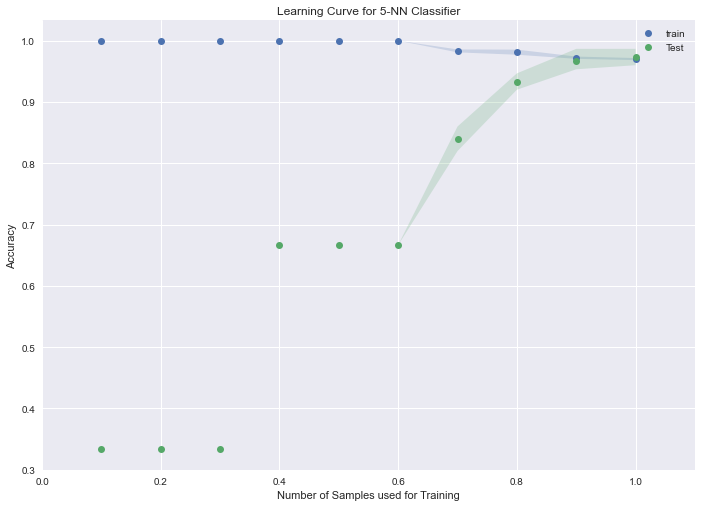

In [42]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.tsplot(joined,
                time=train_sizes,
                condition=['train', 'Test'],
                interpolate=False)
ax.set_title('Learning Curve for 5-NN Classifier')
ax.set_xlabel('Number of Samples used for Training')
ax.set_ylabel('Accuracy')

There are some distinct steps in the testing error. As we move from 70% to 100% of the data used for training, the test performance flattens out near a respectable percent in the high 90s. What about the training side? 
Why does it decrease? With few enough examples, there is a simple enough pattern that our 5-NN can capture all of the training data, until we get to about 60%. After that, we start losing a bit of ground on the training performance.

One takeway: we can convert this percent into a minimum number of examples we think we need for adequate training. We needed almost 100% *of the joined training folds* to get reasonable 5-CV results, which translates into needing 80% of the full dataset for training. If this was inadequate, we could consider fewer CV splits which would up the amount of training data.

### 5.7.2 Complexity Curves

Earlier, when discussing under- and overfitting, we drew a graph taht showed what happened to our training and testing performance as we varied the complexity of our model. Graphing that was buried deep inside some nested loops and drawing functions. We can appropriate `tsplot`, as we did for sample curves, to make the process fit in five logical lines of code. This is the minimized code.

c:\users\scott\.pyenv\pyenv-win\versions\3.9.4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Accuracy')

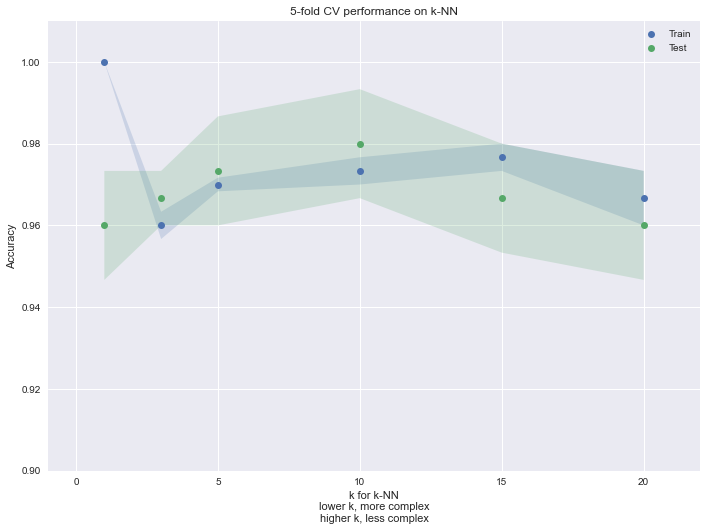

In [43]:
num_neigh = [1, 3, 5, 10, 15, 20]
KNC = neighbors.KNeighborsClassifier
tt = skms.validation_curve(KNC(),
                           iris.data, iris.target,
                           param_name='n_neighbors',
                           param_range=num_neigh,
                           cv=5)

# stack and transpose trick (as above)
ax = sns.tsplot(np.array(tt).transpose(),
                time=num_neigh,
                condition=['Train', 'Test'],
                interpolate=False)

ax.set_title('5-fold CV performance on k-NN')
ax.set_xlabel('\n'.join(['k for k-NN',
                         'lower k, more complex',
                         'higher k, less complex']))

ax.set_ylim(.9, 1.01)
ax.set_ylabel('Accuracy')

Why does 1-NN get 100% training accuracy? Is that a good thing? When *might* it be a good thing?

It is because the training points are classified exactly as their own target value: they are exactly their own nearest neighbor. It's potentially overfitting in the extreme. Now, if there is little or no noise it might be OK.

10-NN might be a good value for our final system to deliver to our customer because it seems to make a good tradeoff between underfitting (bias) and overfitting (variance). We should assess it on a hold-out test set.

## 5.8 Comparing Learners with Cross-Validation

A benefit of CV is that we can see the variability with respect to training on different training sets. We can only do that if we keep each evaluation as a stand-alone value because we need to compare individual values against each other. 



<style>
    td{
    font-size: 50px
}
</style>

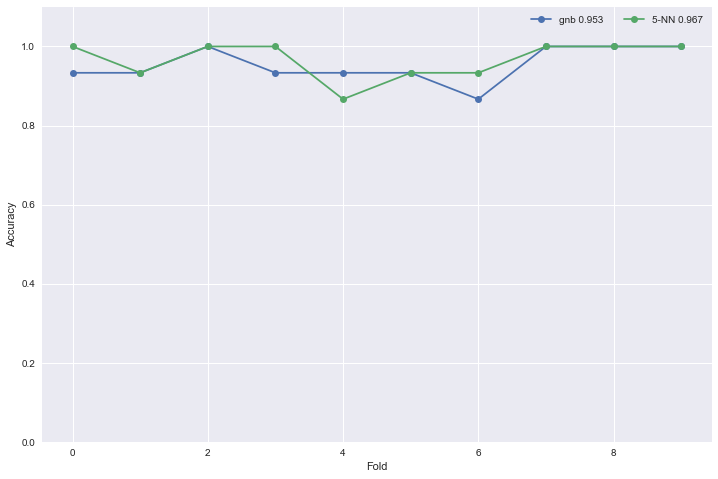

In [44]:
classifiers = {'gnb'  : naive_bayes.GaussianNB(),
               '5-NN' : neighbors.KNeighborsClassifier(n_neighbors=5)}

iris = datasets.load_iris()

fig, ax = plt.subplots(figsize=(12, 8))
for name, model in classifiers.items():
    cv_scores = skms.cross_val_score(model,
                                     iris.data, iris.target,
                                     cv=10,
                                     scoring='accuracy',
                                     n_jobs=-1) # use all cores
    my_lbl = '{} {:.3f}'.format(name, cv_scores.mean())
    ax.plot(cv_scores, '-o', label=my_lbl) # marker=next(markers)

ax.set_ylim(0.0, 1.1)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.legend(ncol=2)